
ДЗ 1:
Дизайн теста

Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

A/B тест

Представим что у нас прошел тест, используем те же самые данные за 2 недели

Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага

СОВЕТ: Т.к бутстрэп считается долго, то для дз отлаживаем код на малом количестве итераций, а результаты уже показываем на 1000+


In [14]:
import os
import hashlib
import zipfile
import datetime
import requests
import collections

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from base64 import b64encode
from scipy.stats import norm

# Review Dataset

In [2]:
interactions = pd.read_csv('../data/interactions.csv')

In [3]:
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [4]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


# Process data

In [5]:
max_date = interactions['last_watch_dt'].max()
last2weeks = max_date - datetime.timedelta(days=14)

last2weeks = interactions[interactions['last_watch_dt'] >= last2weeks]
last2weeks = last2weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [6]:
last2weeks.head(3)

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776


### Outliers

In [7]:
del interactions

<Axes: >

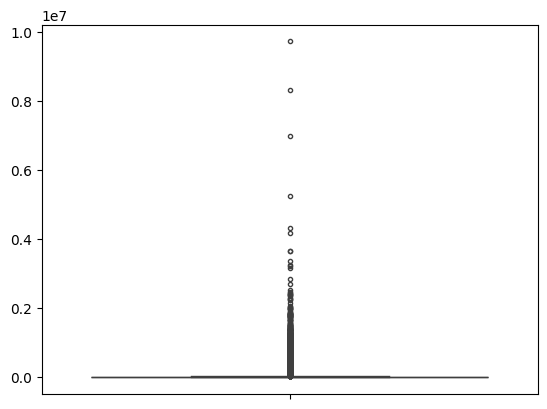

In [8]:
sns.boxplot(last2weeks['total_dur'].values, fliersize=3)

<Axes: ylabel='Density'>

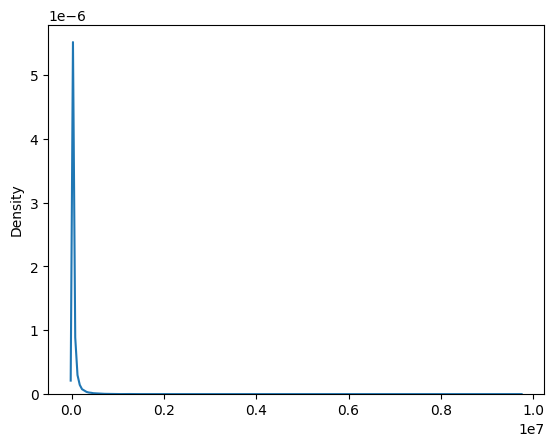

In [9]:
sns.kdeplot(last2weeks['total_dur'].values)

## Drop outliers 3 sigma

In [10]:
last2weeks_std = last2weeks['total_dur'].std()
last2weeks = last2weeks[(last2weeks['total_dur'] < last2weeks_std * 3)]

# Design test

In [11]:
def salt_generator(salt=None):
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df, columns, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(
        lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()
    )

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(
        lambda x: 'A' if x == 0 else 'B')
    )

    return df[columns].drop_duplicates()


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [15]:
correctness = []
values = []

for _ in tqdm(range(1000)):

    new_df = groups_splitter(
        last2weeks.copy(),
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(
        sample_a_mean - sample_b_mean,
        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
    )

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'\nsignificance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


significance: 5.800000000000001%


In [16]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

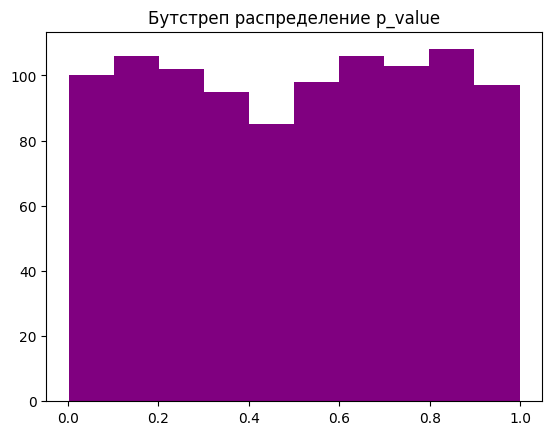

In [17]:
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value")

In [18]:
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.8962942933084895 - p_values равномерное распределение


# Power

## effect 1%

In [19]:
effect = 1.01

correctness = []
values = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(
        last2weeks.copy(),
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    vec_b = vec_b * effect

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(
        sample_a_mean - sample_b_mean,
        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
    )

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'\nsignificance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


significance: 32.5%


Text(0.5, 1.0, 'Бутстреп распределение p_value')

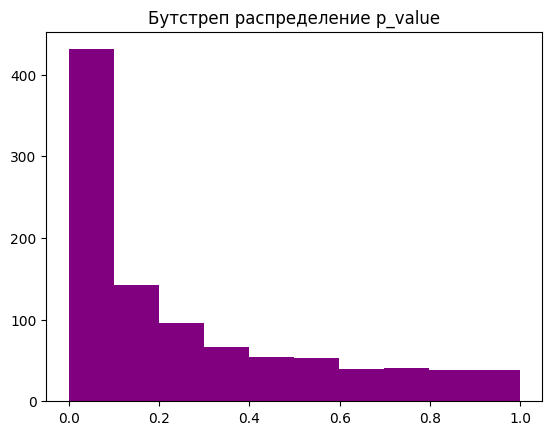

In [20]:
p_values = [get_p_value(dist) for dist in values]
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value")

## Effect 3%

In [21]:
effect = 1.03

correctness = []
values = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(
        last2weeks.copy(),
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    vec_b = vec_b * effect

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(
        sample_a_mean - sample_b_mean,
        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
    )

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'\nsignificance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


significance: 99.3%


Text(0.5, 1.0, 'Бутстреп распределение p_value')

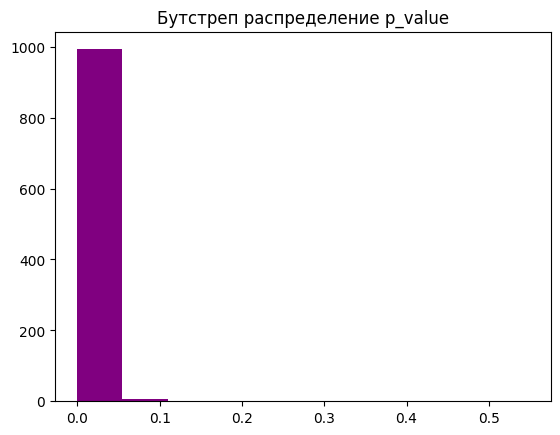

In [22]:
p_values = [get_p_value(dist) for dist in values]
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value")

## Effect 5%

In [23]:
effect = 1.05

correctness = []
values = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(
        last2weeks.copy(),
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    vec_b = vec_b * effect

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(
        sample_a_mean - sample_b_mean,
        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
    )

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'\nsignificance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


significance: 100.0%


Text(0.5, 1.0, 'Бутстреп распределение p_value')

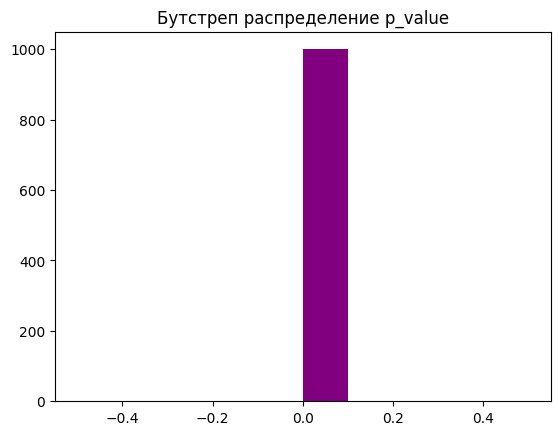

In [24]:
p_values = [get_p_value(dist) for dist in values]
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value")

# MDE

In [25]:
alpha = 0.05
beta = 0.20

def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

print(f'MDE: {get_mde(vec_a, alpha, beta)}')

MDE: 1.3220477086677023


# A/B Test

In [16]:
salt = 'kiontestmodel20210805'

last2weeks['total_dur'] = np.where(last2weeks['total_dur'] < 500, 0, last2weeks['total_dur'])

In [17]:
salt

'kiontestmodel20210805'

In [19]:
new_df = groups_splitter(
  last2weeks.copy(),
  columns=['user_id', 'total_dur', 'group'],
  user_salt=salt,
).drop_duplicates()

vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
vec_b = np.where(vec_b >= vec_b.quantile(0.9), vec_b * 1.025, vec_b)

group_a_mean = calc_bootstrap_mean(vec_a, size=1000)
group_b_mean = calc_bootstrap_mean(vec_b, size=1000)
diff = group_b_mean - group_a_mean

print(get_p_value(diff))

0.030000000000000027
